# Pre-requisites

In [ ]:
%%capture
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import IsolationForest
import datetime as dt
import scipy

# warnings
import warnings
warnings.simplefilter(action='ignore')

import matplotlib
import matplotlib.dates as mdates
# Display
from prettytable import PrettyTable

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Explainability
import lime
import lime.lime_tabular

# Get Data
Reading just 2023 data because
1. Reading 2021 and 2022 was too time consuming. To workaround this, I would need to use
    * Dask
    * Chunking
    * Compression
    * Other hardware options
2. 2021 to some part of 2022 was impacted by covid restrictions. This data would've had significant variations/anomalies.
3. In 2023, we've not had any covid related restrictions and could be considered 'business as usual' as opposed to 2021 and initial 2022.

In [ ]:
soup = BeautifulSoup(requests.get('https://s3-eu-west-1.amazonaws.com/cycling.data.tfl.gov.uk/?list-type=2&max-keys=1500').text)
dfs_list = []

for c in soup.select('contents key'):
    if c.text.startswith('usage-stats') and c.text.endswith('.csv'):
      #if '2021' in c.text or '2022' in c.text or '2023' in c.text:
      if '2023' in c.text:
        filename = 'https://cycling.data.tfl.gov.uk/'+c.text
        #print(filename)

        s = requests.get(filename).content
        dfs_list.append(pd.read_csv(StringIO(s.decode('utf-8')),low_memory=False))

df = pd.concat(dfs_list)

# Data Inspection

In [ ]:
# Keep just 2023 data
df = df[~((df['End date'].str.contains('2022')) | (df['Start date'].str.contains('2022')))]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3794918 entries, 0 to 207959
Data columns (total 11 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Number                int64 
 1   Start date            object
 2   Start station number  object
 3   Start station         object
 4   End date              object
 5   End station number    object
 6   End station           object
 7   Bike number           int64 
 8   Bike model            object
 9   Total duration        object
 10  Total duration (ms)   int64 
dtypes: int64(3), object(8)
memory usage: 347.4+ MB


In [ ]:
# Are there duplicates?
df.drop_duplicates().shape

(3794918, 11)

In [ ]:
# Are there nulls?
df.isna().sum()

Number                  0
Start date              0
Start station number    0
Start station           0
End date                0
End station number      0
End station             0
Bike number             0
Bike model              0
Total duration          0
Total duration (ms)     0
dtype: int64

In [ ]:
# Check time span of data
print('Data Time span: ',df['Start date'].min(),'-',df['Start date'].max())

Data Time span:  2023-01-01 00:00 - 2023-06-19 00:00


In [ ]:
# Check for uniqueness. Are there columns with const. values?
df.nunique()

Number                  3794918
Start date               223023
Start station number       1608
Start station               807
End date                 223348
End station number         1611
End station                 809
Bike number               13601
Bike model                    2
Total duration            22645
Total duration (ms)     1790267
dtype: int64

In [ ]:
# Found some possibly erroneous data during analysis. Dropping them early on
# mask = df['Start station number'].str.contains('old', case=False, na=False)
df=  df[~df['Start station number'].isin(['200217old2','001057_old'])]

In [ ]:
# Grain of the data
df[df['Start date']==df['Start date'].min()]

,Number,Start date,Start station number,Start station,End date,End station number,End station,Bike number,Bike model,Total duration,Total duration (ms)
10049,127692103,2023-01-01 00:00,200203,"King Edward Street, St Pauls",2023-01-01 00:32,1212,"Concert Hall Approach 2, South Bank",17830,CLASSIC,31m 55s,1915404
10050,127692104,2023-01-01 00:00,22179,"Exhibition Road, Knightsbridge",2023-01-01 00:02,2685,"South Kensington Station, South Kensington",55969,CLASSIC,2m 27s,147485
10051,127692105,2023-01-01 00:00,1228,"Southampton Street, Strand",2023-01-01 00:30,22178,"Lindfield Street, Poplar",20225,CLASSIC,30m 10s,1810560
10052,127692106,2023-01-01 00:00,1058,"Edgware Road Station, Marylebone",2023-01-01 00:27,3452,"Panton Street, West End",51193,CLASSIC,27m 27s,1647414
10053,127692107,2023-01-01 00:00,1106,"Rampayne Street, Pimlico",2023-01-01 00:10,1106,"Rampayne Street, Pimlico",13116,CLASSIC,9m 28s,568199
10054,127692108,2023-01-01 00:00,973,"Bethnal Green Road, Shoreditch",2023-01-01 00:23,200247,"Globe Town Market, Bethnal Green",13228,CLASSIC,22m 58s,1378180


#### Observations
1. There are 3794918 records with no duplicates and no nulls
2. Data spans from 1st JAN 2023 to 19th JUN 2023
3. 8 categorical columns and 3 numeric columns. Although one of the numeric colums is actually 'object' type it actually indicates trip duration.
4. Grain of the data - Each record denotes a journey. Data is at the journey level.
5. Pandas profiling could've been used but was time consuming.

# Feature Engineering

In [ ]:
# Derive features from date columns

# Start date features
df['Start_date_time'] = pd.to_datetime(df['Start date'])
df['Start_date'] = pd.to_datetime(df['Start_date_time']).dt.date
df['cyc_start_month'] = pd.to_datetime(df['Start_date_time']).dt.month_name()
df['cyc_start_day'] = pd.to_datetime(df['Start_date_time']).dt.day_name()
df['cyc_start_hour'] = pd.to_datetime(df['Start_date_time']).dt.hour
df['cyc_start_hour'] = pd.to_datetime(df['Start_date_time']).dt.hour
df['cyc_start_min'] = pd.to_datetime(df['Start_date_time']).dt.minute
df['cyc_start_dow'] = pd.to_datetime(df['Start_date_time']).dt.dayofweek
df['cyc_start_month_num'] = pd.to_datetime(df['Start_date_time']).dt.month

# End date features
df['End_date_time'] = pd.to_datetime(df['End date'])
df['End_date'] = pd.to_datetime(df['End_date_time']).dt.date
df['cyc_end_month'] = pd.to_datetime(df['End_date_time']).dt.month_name()
df['cyc_end_day'] = pd.to_datetime(df['End_date_time']).dt.day_name()
df['cyc_end_hour'] = pd.to_datetime(df['End_date_time']).dt.hour
df['cyc_end_min'] = pd.to_datetime(df['End_date_time']).dt.minute
df['cyc_end_dow'] = pd.to_datetime(df['End_date_time']).dt.dayofweek
df['cyc_end_month_num'] = pd.to_datetime(df['End_date_time']).dt.month


In [ ]:
# Function to find whether the day was a weekend anticipating difference in journey patterns on weekdays and weekends.

def is_weekend(x):
  if x in ['Friday','Saturday','Sunday']:
    return 'Weekend'
  else:
    return 'Not Weekend'

df['start_is_weekend'] = df['cyc_start_day'].apply(is_weekend)
df['end_is_weekend'] = df['cyc_end_day'].apply(is_weekend)

In [ ]:
# Bucketize Trip duration column
# 1s = 1000ms
# 1min = 60s
df['trip_duration_mins'] = df['Total duration (ms)']/60000

def bin_f(mins):

  if mins <=30 :
    return "Upto 30mins"
  elif mins >30 and mins<=60:
    return "between 30-60mins"
  elif mins >60 and mins<=120:
    return "between 1-2hr"
  elif mins >120 and mins<=600:
    return "between 2-10hr"
  elif mins >600 and mins<=1440:
    return "between 10-24hr"
  else:
    return "more than 24hr"

df["trip_duration_bins"] = df['trip_duration_mins'].apply(bin_f)

In [ ]:
# Find date of the end of the week - to get summary statistics of all journeys by the end of the week

df['Start date'] = pd.to_datetime(df['Start date'])
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0:
        days_ahead += 7
    return d + dt.timedelta(days_ahead)

df['end_of_week'] = df['Start date'].map(lambda x: next_weekday(x, 3) if  x.weekday() < 3 else x).dt.date

In [ ]:
# Feature capturing route info
df['route'] = df['Start station'] + '-----' + df['End station']

# EDA

### Trip Duration categories

In [ ]:
# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',fontsize='x-small')

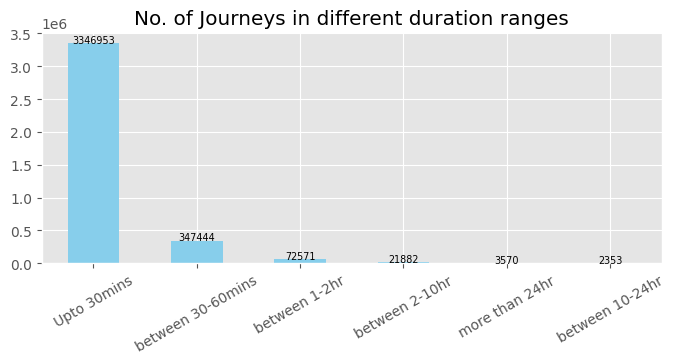

In [ ]:
df["trip_duration_bins"].value_counts().plot(kind='bar',figsize=(8,3),rot=30,color='skyblue',title='No. of Journeys in different duration ranges')
x= df["trip_duration_bins"].value_counts().index
y = df["trip_duration_bins"].value_counts().values
# calling the function to add value labels
addlabels(x, y)
plt.show()

### Shortest Journey

In [ ]:
print('Duration of shortest journey -',df[df['Total duration (ms)'] == df['Total duration (ms)'].min()]['Total duration'].values[0])

Duration of shortest journey - 0s


### Longest Journey

In [ ]:
print('Duration of Longest journey -',df[df['Total duration (ms)'] == df['Total duration (ms)'].max()]['Total duration'].values[0])

Duration of Longest journey - 53d 4h 13m 15s


### Trips shorter than 1 minute

In [ ]:
# 1s = 1000ms
# 60s = 60,000ms

print('Trips shorter than 1 minute -',len(df[df['Total duration (ms)']<60000]))

Trips shorter than 1 minute - 24017


#### Comments/Observations

* It appears the shortest duration of a trip is 0s. Surely no one got anywhere in this time.
* We also observe that there are records where trip duration is less than a minute which is impossible to cover reasonable distance
* All records where trip duration is less than a minute have the same start and end station.

Is this valid data? Lets speculate. It could be -

1. **Data Errors or System glitches**

2. **Short Trips:** Some trips may be extremely short, such as moving a bike from one docking station to another for maintenance or repair. In these cases, the trip duration may be recorded as zero because the actual cycling time was negligible.

3. **User Actions:** Some users may intentionally end a trip prematurely, either by docking the bike and not checking out another bike or by using the app to end the trip early. This could result in a trip duration of zero.

It's important to note that the TfL cycling dataset is very large and contains millions of trip records. Therefore, it's not surprising that there are a few instances where trip durations are recorded as zero. However, the overall accuracy of the data is very high, and these zero-duration trips are likely to be a very small percentage of the total number of trips.

* The longest trip seems to have lasted 53 days.This is likely due to an error in the data. While it is technically possible for a bike rental to last for 53 days, it is highly improbable and would require extenuating circumstances.

* We hence attempt to find and eliminate them using Isolation Forest but the choice of contamination proportion may be totally inaccurate without business inputs, domain knowledge and further investigation.

### Anomaly Detection (ML UseCase -1)
As we all know there are several ways to go about this. I have used Isolation forest. This could also qualify as a Machine Learning Use case the Task requires.

I"m trying to eliminate anomalous records that may have made their way into the data erroneously. This is to give me better/more accurate EDA insights.

In [ ]:
random_state = np.random.RandomState(42)
model=IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.001),random_state=random_state)

model.fit(df[['Total duration (ms)']])

df['scores'] = model.decision_function(df[['Total duration (ms)']])
df['anomaly_score'] = model.predict(df[['Total duration (ms)']])

print('No. of anomalous records - ',len(df[df['anomaly_score']==-1]))

noanodf = df[~ (df['anomaly_score']==-1)]

No. of anomalous records -  3764


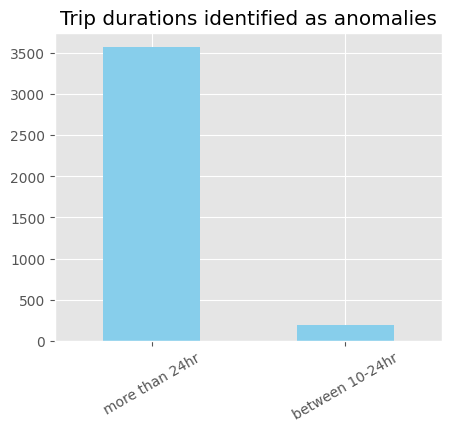

In [ ]:
df[df['anomaly_score']==-1]['trip_duration_bins'].value_counts().plot(kind='bar',figsize=(5,4),rot=30,color='skyblue',title='Trip durations identified as anomalies')
plt.show()

#### Comments/Observations
* Anomalous records have a trip duration of 10 hours or more
* Although this may be possible, it is highly unlikely and requires extenuating circumstances.
* I will assume these are anomalous for this analysis.
* But contamination proportion should be determined with business inputs and appetite for false positives.
* I could further visualize the isolation trees and analyze path length. Choosing to move on for now.

### Bikes

In [ ]:
print('No. of unique bikes-',noanodf['Bike number'].nunique())

No. of unique bikes- 13601


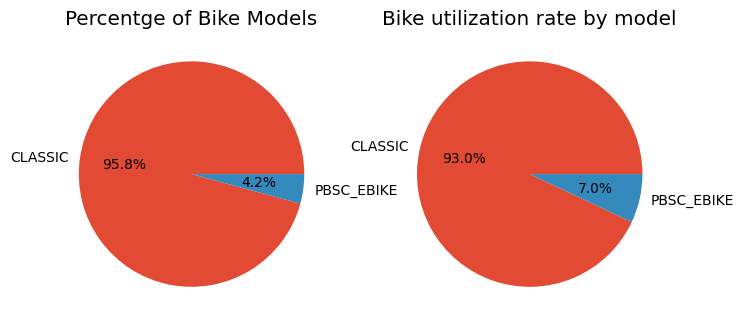

In [ ]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
noanodf.groupby(['Bike model'])['Bike number'].nunique().plot(kind='pie', autopct='%1.1f%%')
plt.title('Percentge of Bike Models')
plt.ylabel('')

plt.subplot(1, 2, 2)
noanodf['Bike model'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Bike utilization rate by model')
plt.ylabel('')
plt.show()


In [ ]:
temp = noanodf.groupby(['Bike model'])['Total duration (ms)'].mean().reset_index(name = 'Avg_duration_ms')
temp['Avg_duration_mins'] = np.round(temp['Avg_duration_ms']/(1000*60),2)
temp

,Bike model,Avg_duration_ms,Avg_duration_mins
0,CLASSIC,1.082754e+06,18.05
1,PBSC_EBIKE,1.071931e+06,17.87


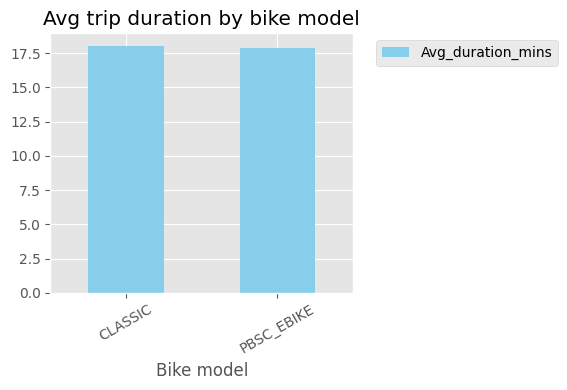

In [ ]:
temp[['Bike model','Avg_duration_mins']].plot(x = 'Bike model',y='Avg_duration_mins',kind='bar',rot=30,title = 'Avg trip duration by bike model',figsize=(8,4),color='skyblue')
plt.legend(bbox_to_anchor = (1.7, 1.0), loc='upper right')
plt.tight_layout()
plt.show()

**Classic bike:**

* traditional; pedal-powered drivetrain
* typically with a single gear or multiple gears.
* Lightweight and easy to maneuver.
* Suitable for short-distance trips and leisure rides.
* Requires physical exertion to pedal and maintain speed.

**PBSC_EBIKE:**

* pedal-powered drivetrain augmented by an electric motor.
* provides electric assistance making it easier to pedal uphill or maintain speed on longer rides.
* Suitable for longer-distance trips, and cyclists with varying physical abilities.
* Requires less physical exertion than a classic bicycle
* Can maintain higher speeds than classic bikes
* higher rental fee

#### Comments/Observations
1. The above differences/features have been listed to be able to relate to what the data shows. The data also shows the e-bikes to have a shorter avg trip duration probably due to its electric assistance. However, the difference is minute :) probably because people don't really know how to use the ebike's ability.
2. There are more classic bikes than e-bikes possibly why the utilization rate of the classic bikes is also higher
3. There a total of 13601 bikes

### Busiest stations

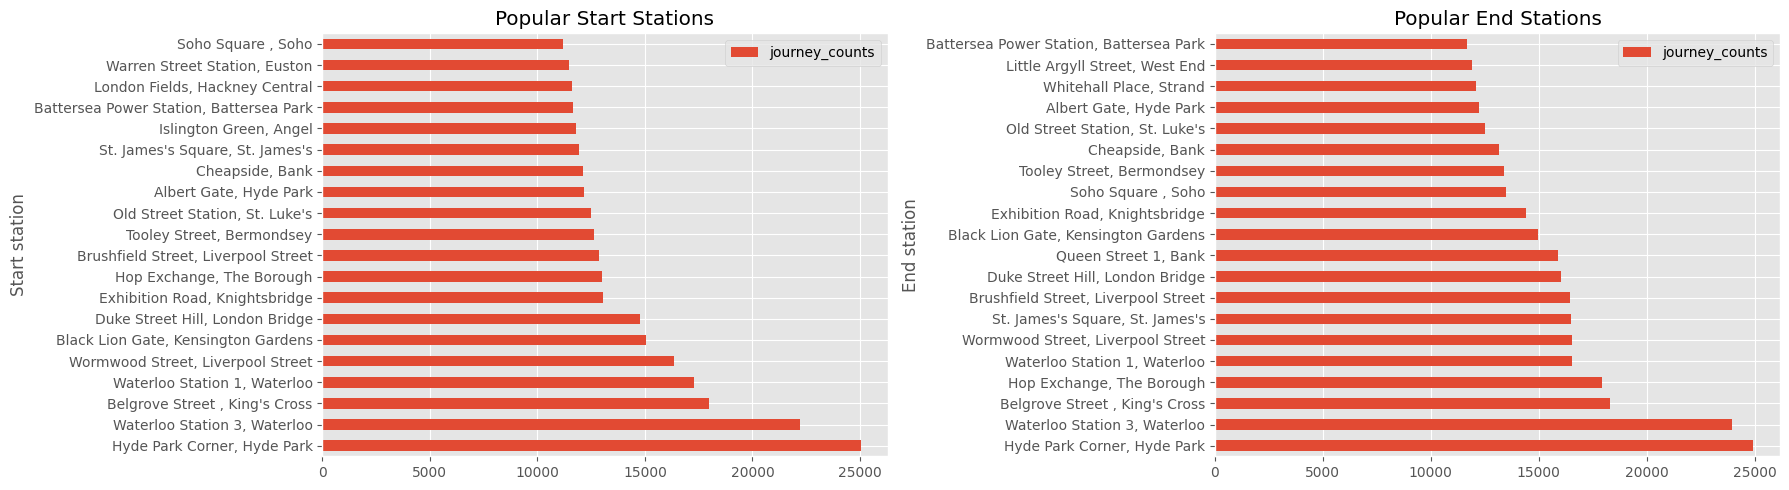

In [ ]:
# create 1x2 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

temp1 = noanodf.groupby(['Start station']).size().reset_index(name='journey_counts').sort_values(by='journey_counts',ascending=False)
temp1.head(20).plot( kind='barh',x='Start station',y='journey_counts',ax=ax1, title='Popular Start Stations')

temp2 = noanodf.groupby(['End station']).size().reset_index(name='journey_counts').sort_values(by='journey_counts',ascending=False)
temp2.head(20).plot( kind='barh',x='End station',y='journey_counts',ax=ax2, title='Popular End Stations')
fig.tight_layout()
plt.show()

#### Comments/Observations

* The list of top 20 busiest start and stop stations overlap significantly. In fact the top 3 are the same i.e. the top 3 busiest stations where most people start their journeys and end their journeys are the same.

* Hyde Park tops the list with 25000 journeys originating and culminating there in 6 months.


### Avg. Trip duration by station pair
Showing the figures in 'hours'

In [ ]:
temp = noanodf.groupby(['route'])['Total duration (ms)'].mean()/3600000
temp = temp.reset_index(name='avg_trip_duration').sort_values(by='avg_trip_duration',ascending=False)
temp['avg_trip_duration'] = round(temp['avg_trip_duration'])
temp.head(10)

,route,avg_trip_duration
299715,"Sun Street, Liverpool Street-----The Vale, Che...",22.0
9101,"All Saints' Road, Portobello-----Wellington Ro...",22.0
205323,"Nevern Place, Earl's Court-----Portman Square,...",22.0
52642,"Buxton Street 1, Shoreditch-----Belvedere Road...",22.0
309572,"Tooley Street, Bermondsey-----Maida Vale, Maid...",22.0
112932,"Finsbury Circus, Liverpool Street-----Mechanic...",22.0
274480,"Soho Square , Soho-----Pennington Street, Wapping",22.0
81584,"Crimscott Street, Bermondsey-----Jubilee Stree...",22.0
89923,"Doric Way , Somers Town-----St. George's Squar...",21.0
178157,"Lambeth Palace Road, Waterloo-----Spencer Park...",21.0


#### Comments/Observation

* We are only displaying the top 10 station pairs with the highest avg. trip duration in hours.
* These stations are only about 20-40 minutes away and the avg. trip duration is nearly 24 hours.
* While this is technically possible due to some of the below reasons, it could as well be an outlier. Some domain/business inputs would help clarify.

**Overnight travel:** Some routes may include overnight travel, resulting in longer trip durations. For instance, if a route operates late at night and resumes early in the morning, the average trip duration could be significantly higher than the actual travel time during regular hours.

**Special services:** Certain routes may operate specific services, such as night buses or weekend services, that have longer trip durations due to reduced frequency or circuitous routes.

**Data errors:**There might be errors in the data, such as incorrect trip durations or mismatches between route codes and actual routes.

**Outliers:** Extreme outliers in the data could skew the average trip duration. For example, if a single trip took an unusually long time due to an unforeseen incident, it could significantly impact the overall average.

Although i've performed anomaly detection and removed outliers already, I could probably increase contamination proportion further and eliminate these as well.

### Popular cycling routes
Synonymous with the most frequented routes

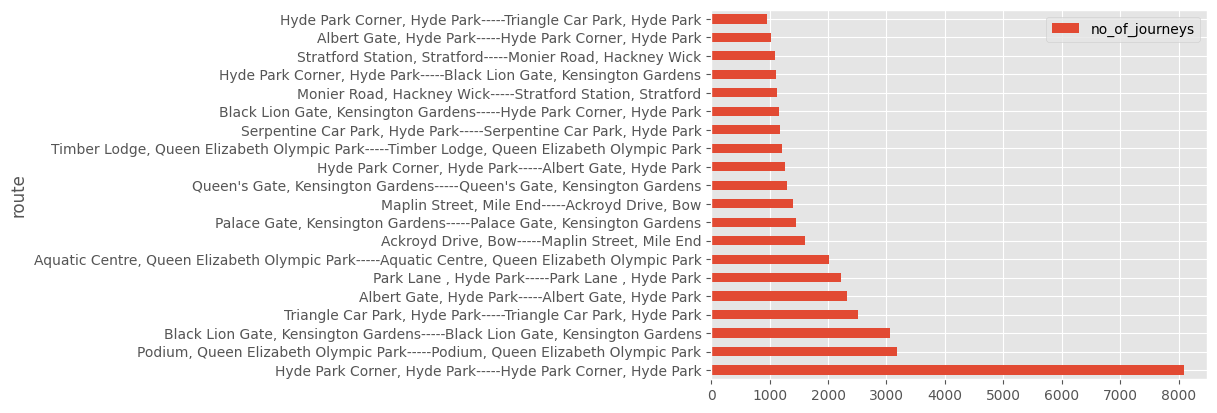

In [ ]:
busy_routes = df.groupby(['route']).size().reset_index(name='no_of_journeys').sort_values(by='no_of_journeys',ascending=False)
busy_routes.head(20).plot( kind='barh', x='route',y='no_of_journeys')
plt.show()

### Least travelled routes

In [ ]:
temp = df.groupby(['Start station','End station']).size().reset_index(name='no_of_journeys').sort_values(by='no_of_journeys',ascending=True)
temp['route'] = temp['Start station'] + '---' + temp['End station']
temp[['route','no_of_journeys']].head(5)

,route,no_of_journeys
214783,"Northumberland Avenue, Strand---Sheepcote Lane...",1
59542,"Chadwell Street, Angel---The Tennis Courts, Th...",1
140504,"Grosvenor Road, Pimlico---Triangle Car Park, H...",1
218662,"Old Street Station, St. Luke's---Star Road, We...",1
115287,"Fire Brigade Pier, Vauxhall---Swan Street, The...",1


#### Comments/Observations

* The winner by a large margin is Hyde park to Hyde park with more than 8000 trips.
* It is followed by Olympic park and Kensington gardens by around 3000 trips
* Figure only shows the top 20 routes with the most trips.

Hyde Park could be a popular TfL cycling origin/dest. station for several reasons:

1. Scenic Beauty
2. Recreational Opportunities
3. Accessibility
4. Connectivity
5. Hyde Park is also host to several events throughout the year
6. Hyde Park has a rich history, dating back to the 17th century. Cyclists can enjoy exploring the park's historical landmarks, such as the Serpentine Lake, the Diana, Princess of Wales Memorial Fountain, and the Speaker's Corner.

### Busiest times of the day

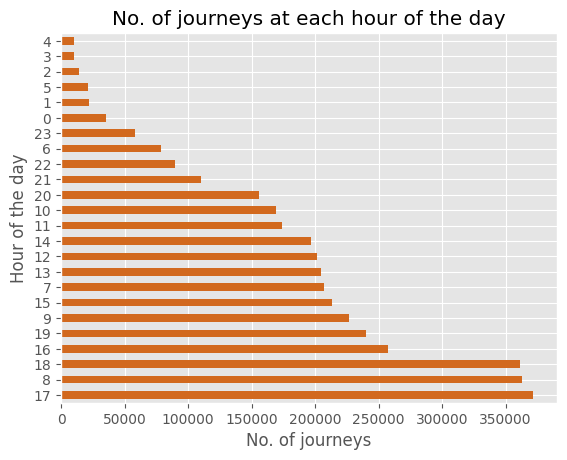

In [ ]:
df.cyc_start_hour.value_counts().plot(kind='barh',title ='No. of journeys at each hour of the day',color='chocolate')
plt.xlabel('No. of journeys')
plt.ylabel('Hour of the day')
plt.show()

#### Comments/Observations

As expected, the highest no. of journeys take place during peak office-home travel hours: 8am, 5pm and 6pm.


### Analyse the distribution of Total Trip Duration(ms)

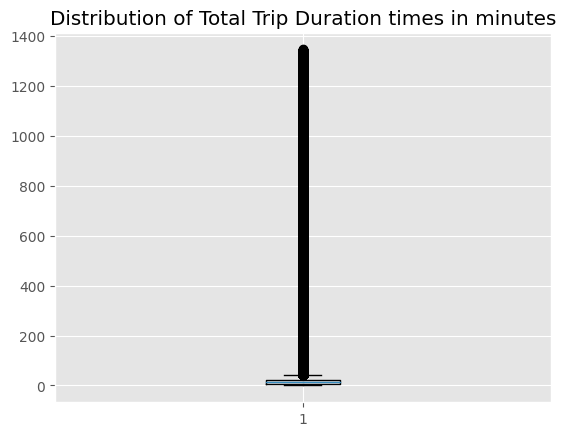

In [ ]:
noanodf['Total duration (ms)'] = noanodf['Total duration (ms)']/(1000*60)
plt.boxplot(noanodf['Total duration (ms)'])
plt.title('Distribution of Total Trip Duration times in minutes')
plt.show()

#### Comments/Observations
 The box plot suggests that the majority of trips are relatively short, with a median duration of 1-3 minutes. However, there is a wide range of trip durations, with some trips taking significantly longer. Further investigation would be required to determine the exact reasons for the long trip durations.

### Change in Avg. trip duration over 2023

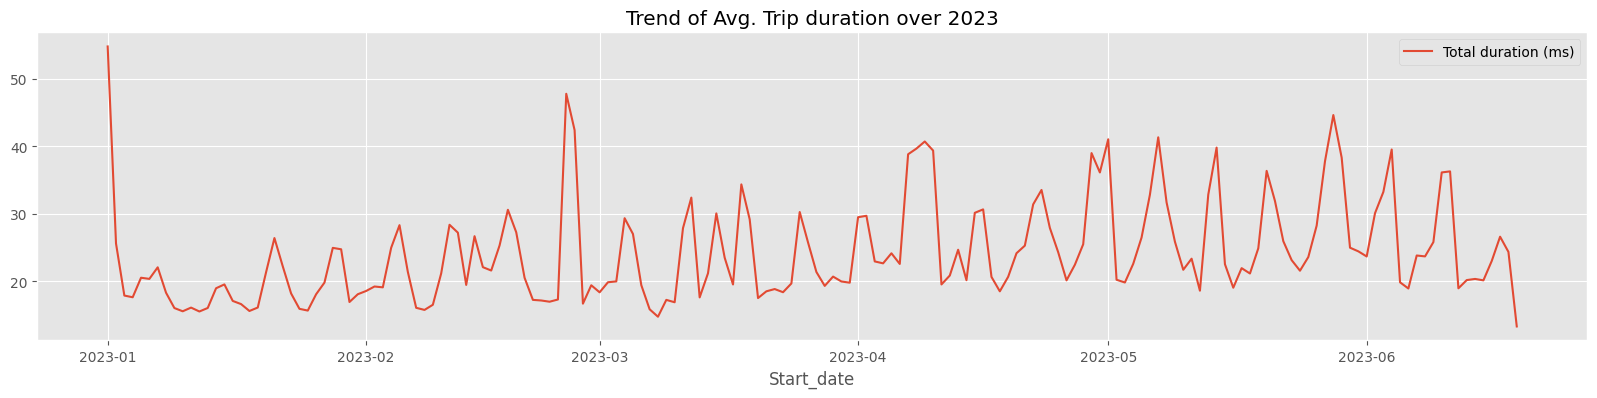

In [ ]:
temp = df.groupby('Start_date')['Total duration (ms)'].mean().reset_index()
temp['Total duration (ms)'] = temp['Total duration (ms)']/60000
temp.set_index('Start_date').plot(figsize=(20,4), title = 'Trend of Avg. Trip duration over 2023')
plt.show()

In [ ]:
temp = df.groupby('Start_date')['Total duration (ms)'].mean().reset_index()
temp['Total duration (ms)'] = np.round(temp['Total duration (ms)']/60000,2)
temp

,Start_date,Total duration (ms)
0,2023-01-01,54.76
1,2023-01-02,25.60
2,2023-01-03,17.89
3,2023-01-04,17.64
4,2023-01-05,20.53
...,...,...
165,2023-06-15,20.14
166,2023-06-16,23.02
167,2023-06-17,26.60
168,2023-06-18,24.35


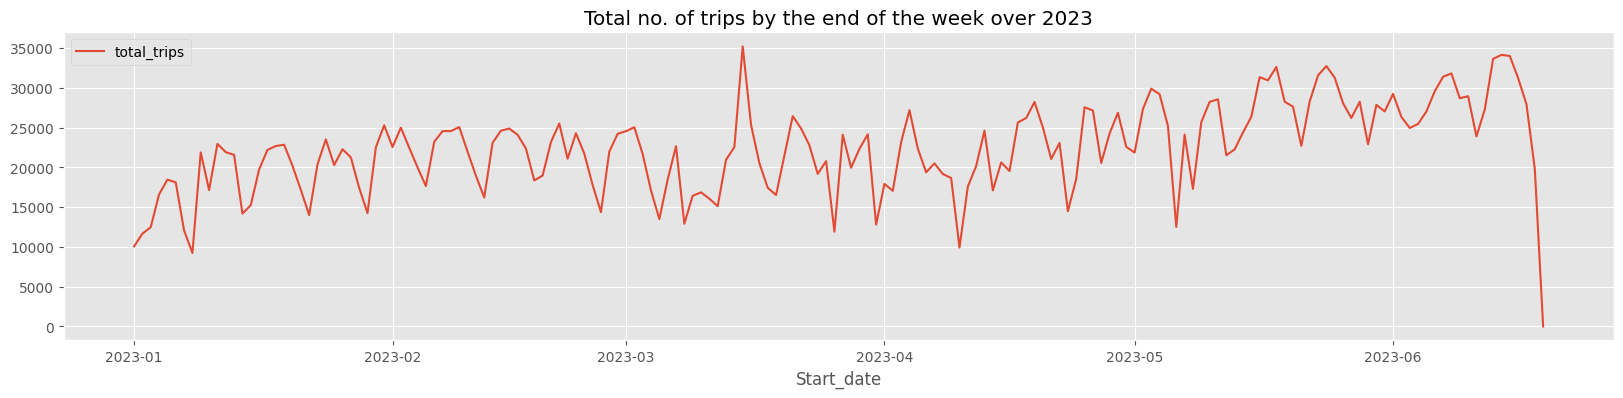

In [ ]:
temp = df.groupby('Start_date').size().reset_index(name = 'total_trips')
temp.set_index('Start_date').plot(figsize=(20,4),title='Total no. of trips by the end of the week over 2023')
plt.show()

#### Comments/Observations
* Overall, it seems the avg. trip duration rises as summer approaches.
* The spikes could mean there are higher averages observed on specific days.
* We'll examine if the spikes over the weekends or other specific days in a subsequent plot.


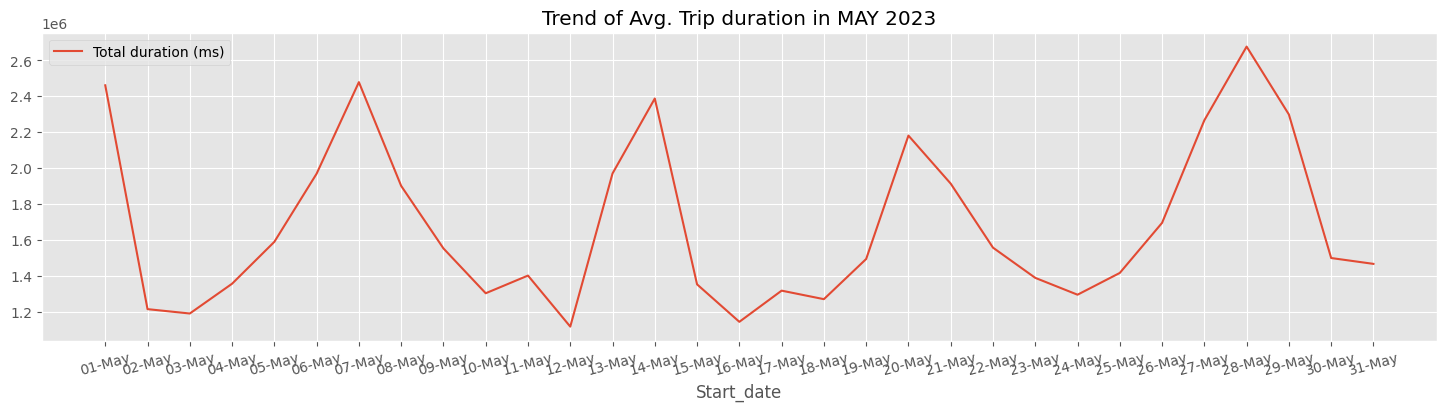

In [ ]:
# Lets zoom in a bit into the above plot to see when exactly the spikes occur

figure = plt.figure()
axes = figure.add_subplot(1, 1, 1)

temp = df[(df.cyc_start_month=='May')]
temp = temp.groupby('Start_date')['Total duration (ms)'].mean().reset_index()
temp.set_index('Start_date').plot(figsize=(18,4),ax=axes)
plt.title('Trend of Avg. Trip duration in MAY 2023')
plt.xticks(temp['Start_date'],rotation=30)
# Formatting time axis tick labels
formatter = matplotlib.dates.DateFormatter('%d-%B')
axes.xaxis.set_major_formatter(formatter)
plt.setp(axes.get_xticklabels(), rotation = 15)

plt.show()

#### Comments/Observations

* I couldn't plot vertical bars for the weekend duration on the plot.
* 5-6-7th, 12-13-14th,20-21-22nd and 26,27-28th may are all weekend dates (Fri-Sat-Sun)
* There are peaks or highest avg. trip durations on Sundays.
* From all the above trend charts, there are lower no. of trips on Sundays but they are of longer duration

### More Trends - Avg. trips each day

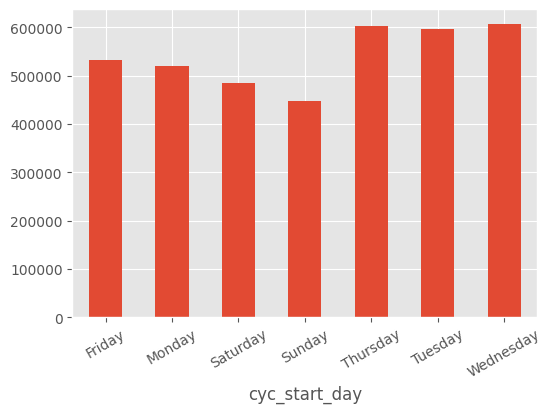

In [ ]:
df.groupby(['cyc_start_day']).size().plot(kind='bar',rot=30,figsize=(6,4))
plt.show()

#### Comments/Observations
* Interestingly, the no. of trips on sunday is the lowest compared to all other days but has the highest avg. trip duration.
* The highest no. of trips are made in the middle of the week - Tue, Wed and Thursday


### London Cycling Habits :)

In [ ]:
daynames = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
monthnames = ["January", "February", "March", "April", "May", "June"]

def trend_plotter(data,feat_name,title):

  data['month_name'] = pd.Categorical(data['cyc_start_month'], categories=monthnames, ordered=True)
  data['start_day_name'] = pd.Categorical(data['cyc_start_day'], categories=daynames, ordered=True)
  data.sort_values(by=['month_name','start_day_name'],inplace=True)

  data.drop(['cyc_start_day','cyc_start_month'],axis=1,inplace=True)
  data = data.pivot(index='month_name',columns='start_day_name',values=feat_name)

  data.plot(kind='bar',figsize=(12,4),rot=30)
  plt.title(title)
  plt.legend(bbox_to_anchor = (1.25, 0.6), loc='center right')
  plt.tight_layout()
  plt.show()

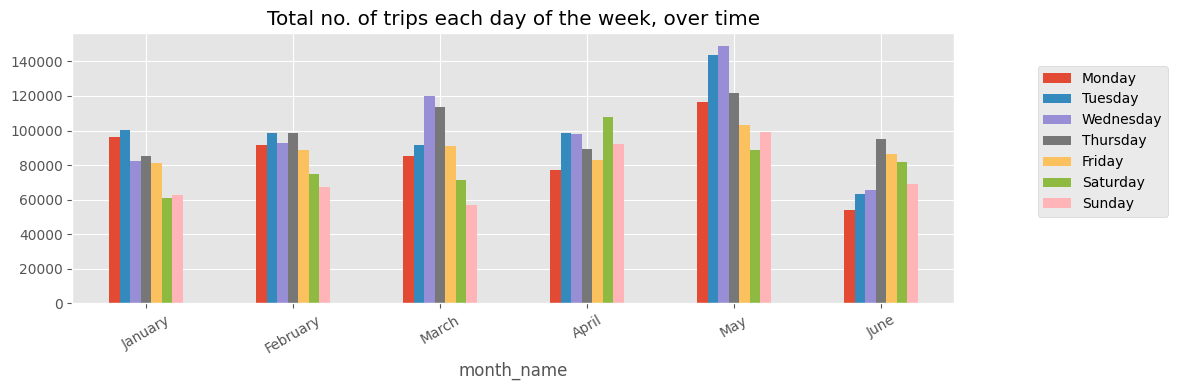

In [ ]:
temp = df.groupby(['cyc_start_day','cyc_start_month']).size().reset_index(name='trip_count').sort_values(by="cyc_start_month")
trend_plotter(temp,'trip_count','Total no. of trips each day of the week, over time')


#### Comments and Observations

**NOTE -** the no of trips is the lowest is june mostly due to the fact that we have data for just the first two weeks.

* The average number of cycling trips per day is highest in the summer months (June-August) and lowest in the winter months (December-February). This is likely due to the more favorable weather conditions during the summer months.

* There is a significant increase in the average number of cycling trips per day on weekends compared to weekdays. This is likely due to the fact that people have more time for leisure activities on weekends.

* Throughout the no. of journeys is higher mid-week than on Monday and Friday most of the months.


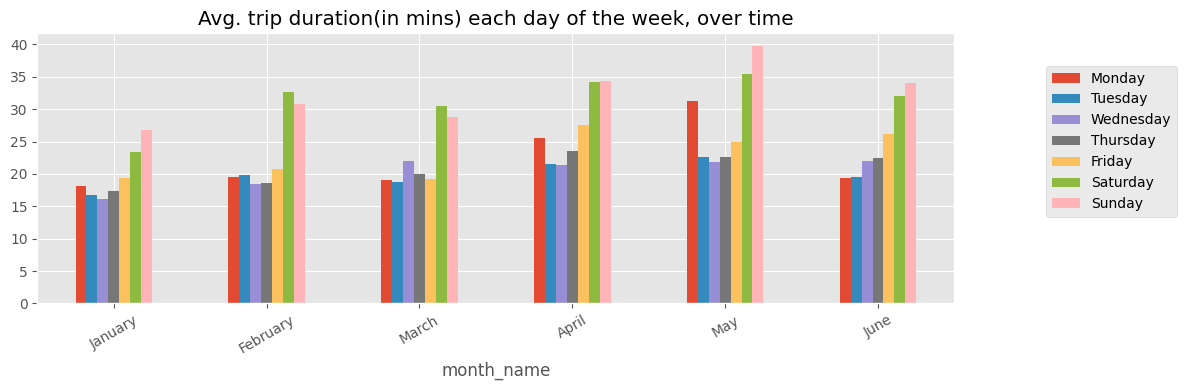

In [ ]:
temp = df.groupby(['cyc_start_day','cyc_start_month'])['Total duration (ms)'].mean().reset_index(name='avg_trip_duration').sort_values(by="cyc_start_month")
temp['avg_trip_duration'] = round(temp['avg_trip_duration']/60000,2)
trend_plotter(temp,'avg_trip_duration','Avg. trip duration(in mins) each day of the week, over time')

#### Comments/Observations

Interestingly, the avg. trip duration is consistently high over the weekends and lower on the weekdays throughout the time span of the data we have.

### Do Daily patterns change over time?

In [ ]:
temp = df[df['cyc_start_day'].isin(['Sunday','Wednesday'])]
temp = temp.groupby(['cyc_start_month','cyc_start_day','cyc_start_hour']).size().reset_index(name='trip_count').sort_values(by="cyc_start_month")
temp['month_name'] = pd.Categorical(temp['cyc_start_month'], categories=monthnames, ordered=True)
temp.drop('cyc_start_month',axis=1,inplace=True)
temp.sort_values(by=['month_name','cyc_start_hour'],inplace=True)

In [ ]:
temp1 = temp[temp.cyc_start_day=='Wednesday']
temp2 = temp[temp.cyc_start_day=='Sunday']

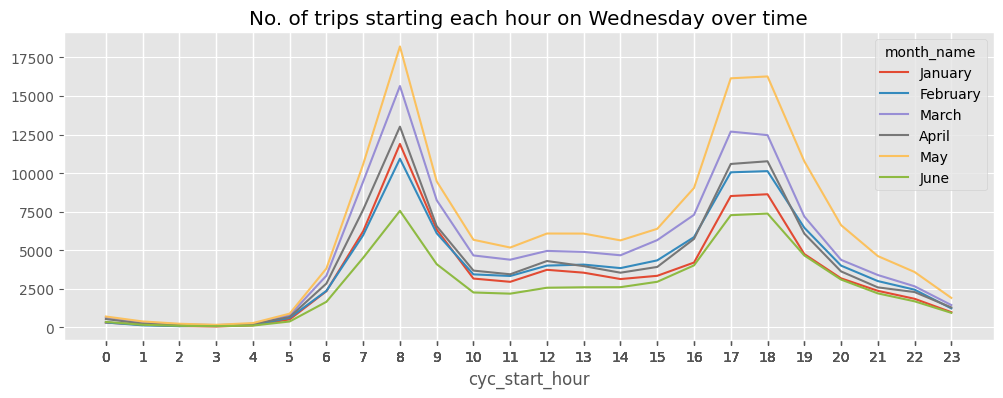

In [ ]:
temp1.pivot(index='cyc_start_hour',columns='month_name',values='trip_count').plot(figsize=(12,4))
plt.title('No. of trips starting each hour on Wednesday over time')
plt.xticks(temp1.cyc_start_hour.values)
plt.show()

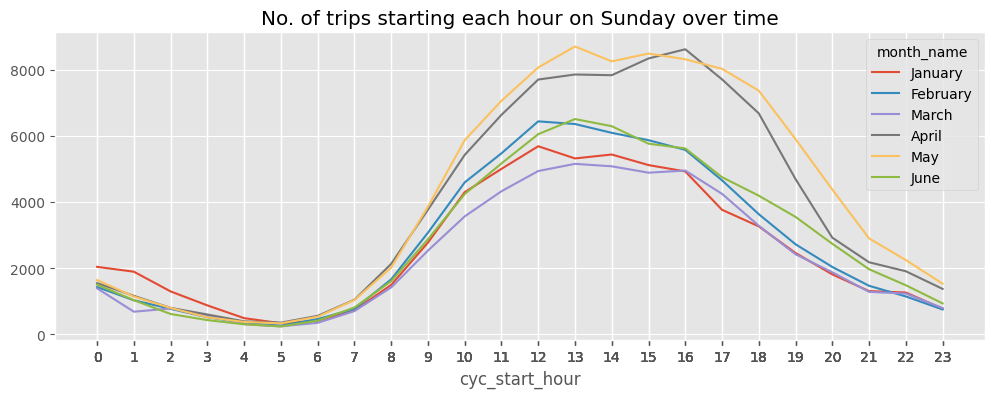

In [ ]:
temp2.pivot(index='cyc_start_hour',columns='month_name',values='trip_count').plot(figsize=(12,4))
plt.title('No. of trips starting each hour on Sunday over time')
plt.xticks(temp2.cyc_start_hour.values)
plt.show()

#### Comments/Observations

I've chosen two days for further investigation for sake of simplicity- one weekday and one weekend day.

**1. London cycling habits - Wednesday**

* Plot 1 shows the no. of trips each hour of all **wednesdays** of each month of 2023 until June.
* We observe that the pattern is consistent across different months only differing in scale.
* We don't fully have June data but otherwise, it is clear to see that the no.of trips is consistently higher in the summer months compared to winter, but differ in the timing or hour of the day.
* There are spikes in the no. of trips made during the peak hours or office going hours - 8AM, 5PM and 6PM.
* There is also a significant increase in the number of cycling trips during the lunch hour (around 12pm). This suggests that people in London are also using cycling to get around during the workday for short trips, such as going to lunch or running errands.


**2. London cycling habits - Sunday**

1. People in London are most likely to cycle during the afternoon on Sundays. The plot shows a clear peak in the number of cycling trips around 12pm, followed by a gradual decline throughout the afternoon and evening.
2. We could speculate that for Leisure activities, many people use their free time on Sundays to engage in leisure activities, such as cycling. The afternoon is a popular time for these activities, as people have more time and energy after a long morning.
3. Longer trips - such as shopping days, day-outs in central London, going to the park, running errands etc. The afternoon is a convenient time for these trips, as people have more time and flexibility.
4. The number of cycling trips is relatively low in the morning and evening on Sundays. This is likely due to the fact that many people are sleeping or relaxing during these hours.

This information can be used to develop policies and programs to promote cycling and make it a more accessible and attractive mode of transportation.

# ML Use Case- 2

I could think of the below use-cases or problems we could solve -

1. Demand prediction at stations
2. Trip Duration prediction
and more..

We will look at **Demand Prediction at station** at different times of the day. Knowing the demand will help us make the required no. of bikes available for use.
I could phrase this as a time series problem and leverage temporal information and relationships but choosing to solve it using a tree-based method.

### Feature selection

As we've already engineered features, we go to feature selection.
1. Eliminate id features - number
2. correlated features.
3. Total duration in words
3. anomaly score
4. end date and end station

In [ ]:
feat_to_drop = ['Number','End date','End station','end_is_weekend','trip_duration_mins','route','scores','anomaly_score','Start_date_time','Start_date',
                'Start date','Start station','end_of_week','End_date_time','End_date','Total duration (ms)','Total duration','Bike number','start_is_weekend',
                'cyc_start_month',	'cyc_start_day','cyc_end_month'	,'cyc_end_day','cyc_start_min','cyc_end_min','End station number','cyc_end_hour'  , 'cyc_end_dow','cyc_end_month_num']
mldf = noanodf.drop(feat_to_drop,axis=1)
mldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3791009 entries, 0 to 207959
Data columns (total 6 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   Start station number  object
 1   Bike model            object
 2   cyc_start_hour        int64 
 3   cyc_start_dow         int64 
 4   cyc_start_month_num   int64 
 5   trip_duration_bins    object
dtypes: int64(3), object(3)
memory usage: 202.5+ MB


### Data Prep

In [ ]:
# Map bike models to numeric values
mldf['Bike model'] = mldf['Bike model'].map({'CLASSIC':1,'PBSC_EBIKE':0})

# Convert station number to numeric
mldf['Start station number'] = mldf['Start station number'].astype(int)

In [ ]:
#mldf.trip_duration_bins.value_counts()
#mldf = mldf[~(mldf.trip_duration_bins=='between 10-24hr')]
#mldf = mldf[(mldf.cyc_start_hour>6) & (mldf.cyc_start_hour<21)]

In [ ]:
# aggregate data to station-bike model- start hour- start day of the week - start month - trip duration bins grain
temp = mldf.groupby(list(mldf.columns)).size().reset_index(name='trip_counts')

# one-hot encode trip duration and concat to original df
data = pd.concat([temp[['Start station number',	'Bike model',	'cyc_start_hour'	,'cyc_start_dow',	'cyc_start_month_num', 'trip_counts']],pd.get_dummies(temp.trip_duration_bins)],axis=1)

In [ ]:
# Define predictors and target
X = data.drop(['trip_counts'],axis=1)
y = data[['trip_counts']]

In [ ]:
# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

### Model Training/Selection

I've removed the gridsearch cv code written to choose best hyperparameters as it was time consuming. I have not focused on getting better performance.

In [ ]:
# Define model hyperparameters and perform cross validation
num_round = 100
params = {
    "objective": "regression",
    "metric": ["mse", "mape"],
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "reg_alpha" : 1,
    "reg_lambda" : 0.48,
    'nthread': -1,
    'verbose':-1
}

train_data = lgb.Dataset(X_train,label= y_train)
test_data = lgb.Dataset(X_test, label= y_test)

cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=num_round,
    nfold=5,
    stratified=False,
)

# cv_results.keys()
# dict_keys(['valid l2-mean', 'valid l2-stdv', 'valid mape-mean', 'valid mape-stdv'])

model = lgb.train(params, train_data, 100)

In [ ]:
t = PrettyTable(['Metric','Train','Validation','Test'])
t.title = 'MSE and MAPE Scores'
t.add_row(['MSE', np.round(np.mean(mean_squared_error(y_train, model.predict(X_train))),2),
           round(np.mean(cv_results['valid l2-mean']),2),
           round(mean_squared_error(y_test, model.predict(X_test)),2)  ])

t.add_row(['MAPE', np.round(np.mean(mean_absolute_percentage_error(y_train, model.predict(X_train))),2)*100,
           round(np.mean(cv_results['valid mape-mean']),2)*100,
           round(mean_absolute_percentage_error(y_test, model.predict(X_test)),2)*100  ])
print(t)

+-------------------------------------+
|         MSE and MAPE Scores         |
+--------+-------+------------+-------+
| Metric | Train | Validation |  Test |
+--------+-------+------------+-------+
|  MSE   | 19.48 |   21.81    | 19.73 |
|  MAPE  |  82.0 |    94.0    |  83.0 |
+--------+-------+------------+-------+


### Interpretability/Explainability

In [ ]:
# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test.columns,verbose=True, mode='regression',random_state=42)

# Choose the last instance and use it to predict the results
exp = explainer.explain_instance(X_test.iloc[-1].values, model.predict)
exp.show_in_notebook()

Intercept 2.546030399226164
Prediction_local [3.5863623]
Right: 8.961068289414147


#### Comments/Observations

Clearly, trip duration bin, journey start hour, station number and day of the week are important attributes determining predicted value of trip_counts.

### More on the problem itself -

Forecasting demand at cycle hire stations can help in a number of ways:

1. Reducing waiting times:
2. Optimizing resource allocation
3. Improving customer experience


### Recommendations
1. Based on forecasted demand, we could estimate how many bikes are needed and made it available at the station for usage at the hour.

Colab. with other Org.
2. Share data to develop cycling infra.
3. Develop targeted safety initiatives in accident prone areas
4. Partner with local businesses to offer discounts or promotions for cyclists

Targetted marketing activities
1. Promotion based on traffic/ demographics
2 Discounted rides during specific hours
3. Collect more data on user and their preferences
4. Promote guided cycling tours or pub crawls

# Incomplete activities/Next steps
1. Not attempting error analysis/debugging to understand why Validation error is quite low compared to Train/Test errors
2. Not attempting hyperparameter tuning
3. Not experimenting with other modelling paradigms
4. Not comparing performance with and without outliers where outliers could be records that have trip duration>10hrs
5. I could have also tried quantile regression and confidence intervals for predictions
6. Because this is a time series dataset with seasonal patterns, examining how the ML model does in terms of predictions during the seasonal period would be useful to evaluate if this is a good technique for demand forecasting.

Leaving the above undone due to time constraints.